# Global Black Box Optimization with RNNS
Project by Pattarawat Chormai and Felix Sattler ||
Supervised by Raphael Holca-Lamarre

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import visualize as viz
import benchmarkfunctions as bf
import gpfunctions as gp
import lstm_model
import data

## Set all the Hyperparameters

In [2]:
# Data
load_data = False
save_data = False
dim = 2
n_train = 1600
n_test = 160
n_bumps = 5
l = 2/n_bumps*np.sqrt(dim)
n_mc_samples = 1000
max_x_abs_value = 1.0
kernel = gp.rbf_kernel
function = gp.normalized_gp_function

# LSTM Model
n_hidden = 100
n_steps = 20

# Optimization
x_start = np.zeros(dim).reshape(1,dim)
epochs = 200
gradient_clipping = 1.0
forget_bias = 5.0
rate_init = 0.005
rate_final = 0.0001
rate_decay = (rate_final/rate_init)**(1/epochs)
batch_size = 128
stddev = 0.00
loss_type = ["MIN", "SUM", "WSUM", "OI", "OI_UPDATED", "SUMIN", "WSUM_EXPO"][4]

# Visualization
visualize = True

## Create Training Data or load from Disk

In [3]:
# Create Data or Load Data from Disk
if load_data:
    X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = data.load_data
else:
    X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    data.gen_data(n_train, n_test, dim, n_bumps, l, kernel, n_mc_samples)
# Save Data to Disk
if save_data:
    save_data(n_train, n_test, dim, n_bumps, l, n_mc_samples = 100)
        
data_train = (X_train, A_train, min_train, max_train)
data_test = (X_test, A_test, min_test, max_test)

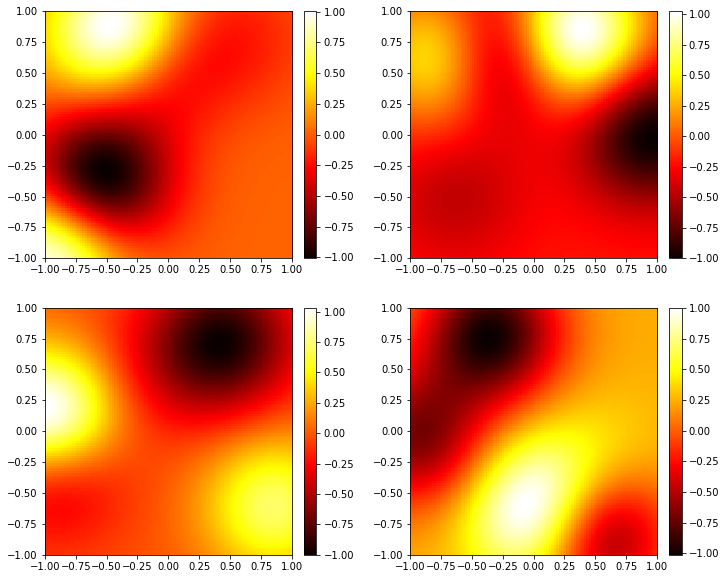

In [4]:
# Visualize Training Data
if visualize: viz.plot_gp_data_sample(4, X_train, A_train, min_train, max_train, l, kernel, function)

## Build the Training Graph

In [5]:
# Build the training graph, collect placeholders, sample sequence and lstmcell parameters 
Xt, At, mint, maxt, samples_x, samples_y, x_0, cell, weights = \
    lstm_model.build_training_graph(n_bumps, dim, n_hidden, forget_bias, n_steps, l, kernel, function)
placeholders = {"Xt": Xt, "At": At, "mint": mint, "maxt": maxt, "x0": x_0}

## Start a Session and start training

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [7]:
train_logs = lstm_model.train_model(sess, placeholders, samples_x, samples_y, epochs, batch_size, data_train, data_test,
                     rate_init, rate_decay, gradient_clipping, loss_type, x_start, max_x_abs_value, log = True)

Ep:    0 | TrainLoss: -0.516 | TrainMin: -0.531 | TestLoss: -0.476 | TestMin: -0.492
Ep:    1 | TrainLoss: -0.592 | TrainMin: -0.659 | TestLoss: -0.648 | TestMin: -0.706
Ep:    2 | TrainLoss: -0.755 | TrainMin: -0.752 | TestLoss: -0.756 | TestMin: -0.755
Ep:    3 | TrainLoss: -0.721 | TrainMin: -0.757 | TestLoss: -0.712 | TestMin: -0.761
Ep:    4 | TrainLoss: -0.580 | TrainMin: -0.740 | TestLoss: -0.587 | TestMin: -0.735
Ep:    5 | TrainLoss: -0.716 | TrainMin: -0.725 | TestLoss: -0.737 | TestMin: -0.749
Ep:    6 | TrainLoss: -0.772 | TrainMin: -0.780 | TestLoss: -0.798 | TestMin: -0.813
Ep:    7 | TrainLoss: -0.797 | TrainMin: -0.799 | TestLoss: -0.819 | TestMin: -0.826
Ep:    8 | TrainLoss: -0.817 | TrainMin: -0.818 | TestLoss: -0.811 | TestMin: -0.816
Ep:    9 | TrainLoss: -0.822 | TrainMin: -0.824 | TestLoss: -0.821 | TestMin: -0.828
Ep:   20 | TrainLoss: -0.821 | TrainMin: -0.818 | TestLoss: -0.815 | TestMin: -0.812
Ep:   40 | TrainLoss: -0.849 | TrainMin: -0.848 | TestLoss: -0.82

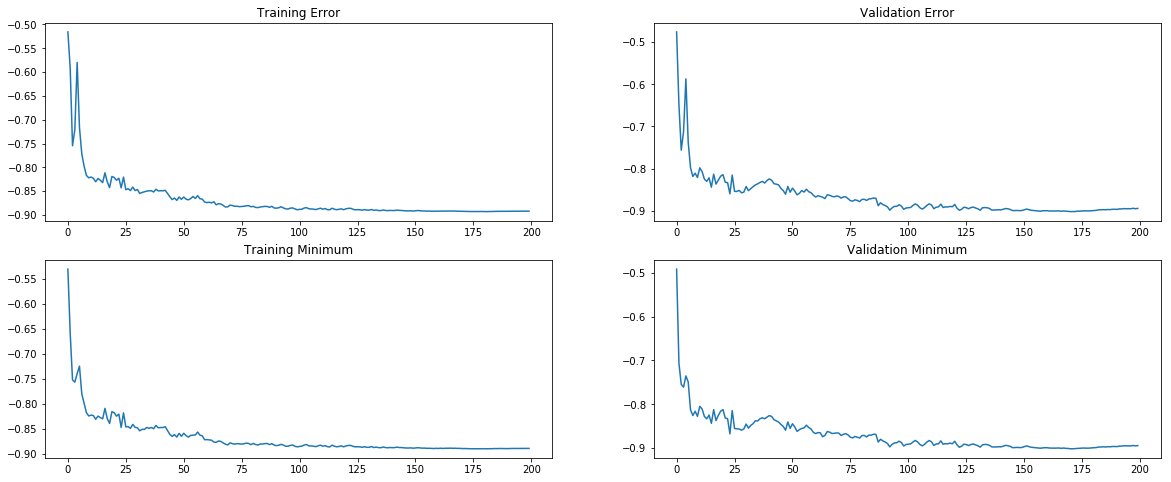

In [8]:
viz.visualize_learning(train_logs)

## Evaluate the Model on Training Data

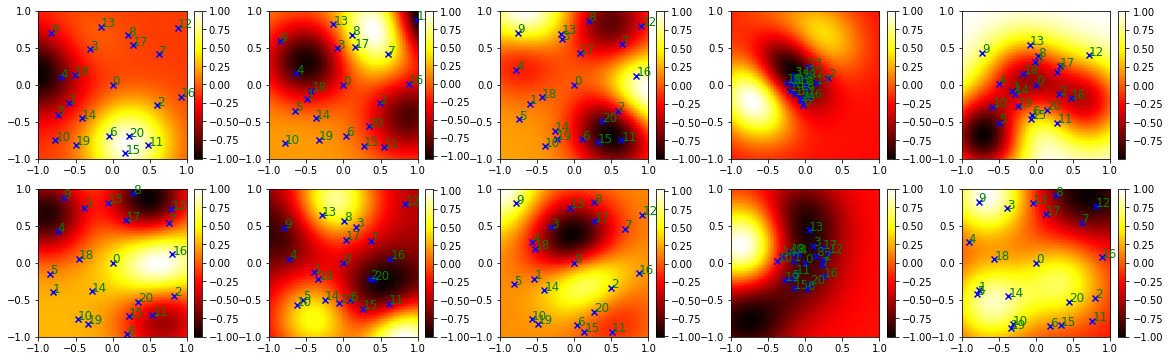

In [9]:
# Show results on Training Data
samples_train_x, samples_train_y = \
        lstm_model.get_samples(sess, placeholders, samples_x, samples_y, data_train, x_start)
    
viz.plot_gp_results_sample(10, X_train, A_train, min_train, max_train, l, samples_train_x, samples_train_y, kernel, function)

## Evaluate the Model on Test Data

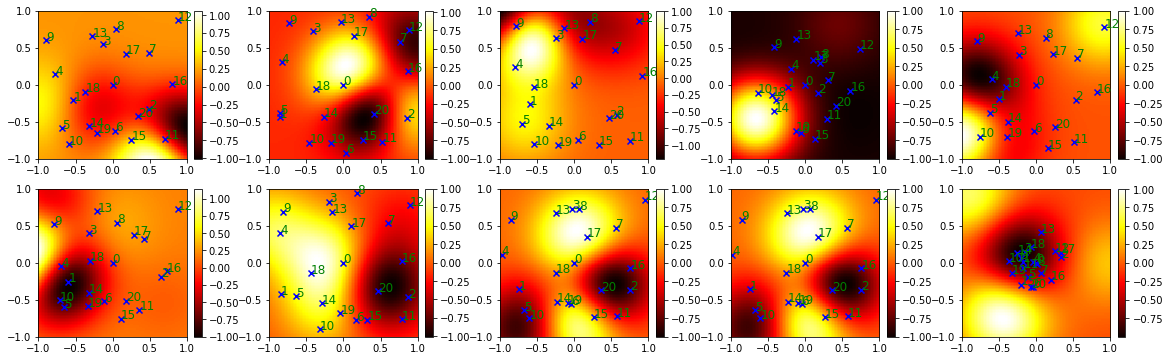

In [10]:
# Show results on Test Data
samples_test_x, samples_test_y = \
        lstm_model.get_samples(sess, placeholders, samples_x, samples_y, data_test, x_start)

viz.plot_gp_results_sample(10, X_test, A_test, min_test, max_test, l, samples_test_x, samples_test_y, kernel, function)

## Evaluate the Model on Benchmark Functions

In [11]:
f_bm = [bf.branin, bf.goldstein_price, bf.hartmann3, bf.hartmann6][0]
f_bm_tf = [bf.branin_tf, bf.goldstein_price_tf, bf.hartmann3_tf, bf.hartmann6_tf][0]

In [12]:
samples_benchmark_x, samples_benchmark_y = \
        lstm_model.get_benchmark_samples(sess, f_bm_tf, cell, weights, dim, n_hidden, n_steps, x_start)

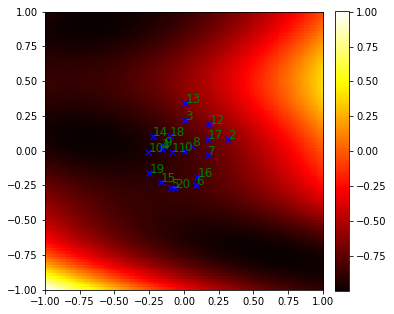

In [13]:
viz.plot_result(f_bm, dim, 1, samples_benchmark_x, samples_benchmark_y)

## Generate Sequence of sample points sequentially

In [39]:
def get_y(x):
    # Can be any arbitrary function that gets a (1,dim) numpy array as input and returns a (1,1) numpy array
    return np.sum(x**2).reshape(1,1)

def generate_sample_sequence(x0, steps):
    h_0 = tf.zeros([1, n_hidden])
    c_0 = tf.zeros([1, n_hidden])

    x = tf.constant(x0, dtype=tf.float32)
    state = (c_0, h_0)

    y0 = get_y(x0)
    y = tf.constant(y0, dtype=tf.float32)
    
    samples_x = [x0]
    samples_y = [y0]
    
    for i in range(steps):
        x, state = lstm_model.next_sample_point(x,y,state,cell,weights, scope="rnn_cell")
        x_np = sess.run(x)
        y_np = get_y(x_np)
        y = tf.constant(y_np, dtype=tf.float32)
        
        samples_x += [x_np]
        samples_y += [y_np]
        
    return samples_x, samples_y

In [44]:
samples_x, samples_y = generate_sample_sequence(np.zeros([1,dim]), steps = 20)

In [45]:
samples_x

[array([[ 0.,  0.]]),
 array([[-0.25986582, -0.60436624]], dtype=float32),
 array([[-0.40190166,  0.57059586]], dtype=float32),
 array([[ 0.56635976, -0.34581956]], dtype=float32),
 array([[ 0.15182486, -0.835832  ]], dtype=float32),
 array([[-0.56065506, -0.70698029]], dtype=float32),
 array([[-0.71379608,  0.02988848]], dtype=float32),
 array([[ 0.34993142,  0.43248579]], dtype=float32),
 array([[ 0.74199456,  0.01430896]], dtype=float32),
 array([[ 0.65638566, -0.97055638]], dtype=float32),
 array([[-0.76480359, -0.52435327]], dtype=float32),
 array([[-0.80408102,  0.69698584]], dtype=float32),
 array([[ 0.58227253,  0.62257004]], dtype=float32),
 array([[ 0.6346122 , -0.22252002]], dtype=float32),
 array([[-0.24188532, -0.50810504]], dtype=float32),
 array([[-0.73366195,  0.08865815]], dtype=float32),
 array([[-0.17911653,  0.71143973]], dtype=float32),
 array([[ 0.38605723,  0.37176844]], dtype=float32),
 array([[ 0.17816108, -0.24470568]], dtype=float32),
 array([[-0.47829831, -0